In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [7]:
import pathlib
data_dir = pathlib.Path("_finalDataSetBatch")


In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

318


In [9]:
a = list(data_dir.glob('OLD 59/*'))
b = list(data_dir.glob('mid2000s 56/*'))
c = list(data_dir.glob('late2000s 66/*'))
d = list(data_dir.glob('early2010s 70/*'))
e = list(data_dir.glob('late2010s 67/*'))

## Create a dataset

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 318 files belonging to 5 classes.
Using 255 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 318 files belonging to 5 classes.
Using 63 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['OLD 59', 'early2010s 70', 'late2000s 66', 'late2010s 67', 'mid2000s 56']


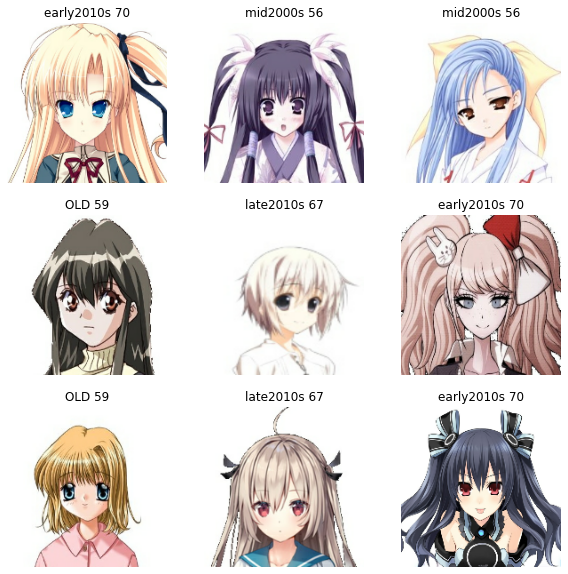

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
normalization_layer = layers.Rescaling(1./255)

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [19]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [22]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
8/8 [==============================] - 7s 731ms/step - loss: 1.8729 - accuracy: 0.1647 - val_loss: 1.6187 - val_accuracy: 0.2222
Epoch 2/10
8/8 [==============================] - 5s 650ms/step - loss: 1.6057 - accuracy: 0.2784 - val_loss: 1.5868 - val_accuracy: 0.2381
Epoch 3/10
8/8 [==============================] - 5s 694ms/step - loss: 1.5048 - accuracy: 0.4392 - val_loss: 1.5424 - val_accuracy: 0.3016
Epoch 4/10
8/8 [==============================] - 6s 713ms/step - loss: 1.3221 - accuracy: 0.4392 - val_loss: 1.5630 - val_accuracy: 0.3333
Epoch 5/10
8/8 [==============================] - 5s 673ms/step - loss: 1.1272 - accuracy: 0.5765 - val_loss: 1.6150 - val_accuracy: 0.2540
Epoch 6/10
8/8 [==============================] - 6s 818ms/step - loss: 0.8509 - accuracy: 0.6902 - val_loss: 1.9032 - val_accuracy: 0.2857
Epoch 7/10
8/8 [==============================] - 6s 773ms/step - loss: 0.6665 - accuracy: 0.7843 - val_loss: 2.2046 - val_accuracy: 0.2540
Epoch 8/10
8/8 [====

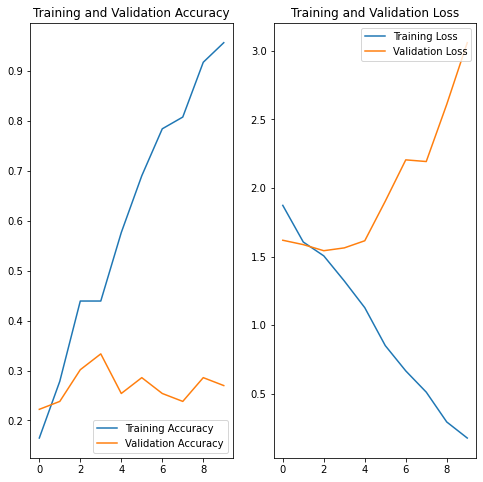

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

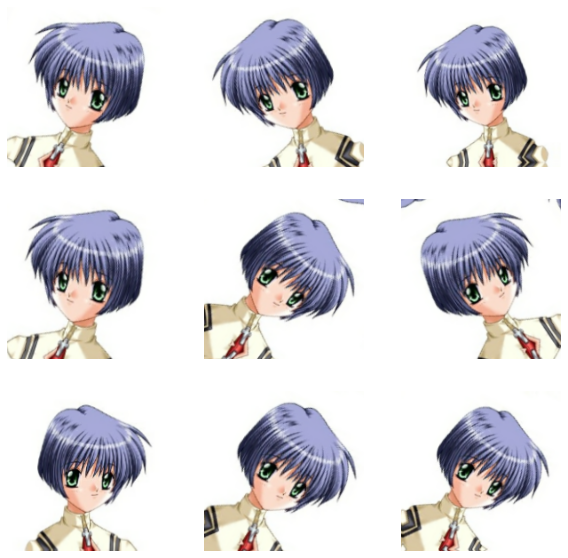

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [26]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [29]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
8/8 [==============================] - 7s 738ms/step - loss: 1.7133 - accuracy: 0.1843 - val_loss: 1.6187 - val_accuracy: 0.1746
Epoch 2/15
8/8 [==============================] - 6s 691ms/step - loss: 1.6067 - accuracy: 0.2471 - val_loss: 1.5944 - val_accuracy: 0.2540
Epoch 3/15
8/8 [==============================] - 7s 826ms/step - loss: 1.5895 - accuracy: 0.2588 - val_loss: 1.5766 - val_accuracy: 0.2381
Epoch 4/15
8/8 [==============================] - 7s 834ms/step - loss: 1.5641 - accuracy: 0.2941 - val_loss: 1.5608 - val_accuracy: 0.2540
Epoch 5/15
8/8 [==============================] - 6s 737ms/step - loss: 1.5094 - accuracy: 0.3608 - val_loss: 1.5314 - val_accuracy: 0.3492
Epoch 6/15
8/8 [==============================] - 6s 714ms/step - loss: 1.4932 - accuracy: 0.3843 - val_loss: 1.7008 - val_accuracy: 0.2857
Epoch 7/15
8/8 [==============================] - 6s 727ms/step - loss: 1.4132 - accuracy: 0.3529 - val_loss: 1.6104 - val_accuracy: 0.3016
Epoch 8/15
8/8 [====

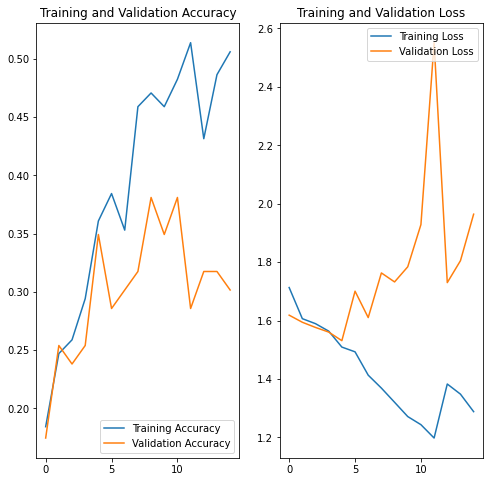

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
test_url = "https://static.wikia.nocookie.net/grisaia/images/e/e3/Makina_Irisu.png/revision/latest?cb=20140606172911"
test_path = tf.keras.utils.get_file('makinaGrisaia', origin=test_url)

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to late2000s 66 with a 68.62 percent confidence.


In [32]:
test_url = "https://static.wikia.nocookie.net/grisaia/images/d/d0/Amane_Suou.png/revision/latest?cb=20140606165927"
test_path = tf.keras.utils.get_file('akane_Grisaia', origin=test_url)

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to OLD 59 with a 48.17 percent confidence.


In [33]:
test_url = "https://static.wikia.nocookie.net/grisaia/images/8/8d/Sachi_Komine.png/revision/latest/scale-to-width-down/250?cb=20140606174554"
test_path = tf.keras.utils.get_file('sachi_Grisaia', origin=test_url)

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to OLD 59 with a 51.67 percent confidence.


In [34]:
test_url = "https://static.wikia.nocookie.net/grisaia/images/9/99/Yumiko_Sakaki.png/revision/latest/scale-to-width-down/250?cb=20140605185623"
test_path = tf.keras.utils.get_file('yumiko_Grisaia', origin=test_url)

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to OLD 59 with a 77.52 percent confidence.


In [35]:
test_url = "https://static.wikia.nocookie.net/grisaia/images/6/6b/Michiru_Matsushima.png/revision/latest/scale-to-width-down/250?cb=20140606171249"
test_path = tf.keras.utils.get_file('michiru_Grisaia', origin=test_url)

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to late2000s 66 with a 85.67 percent confidence.


In [36]:
test_url = "https://www.pngitem.com/pimgs/m/166-1665620_archived-danganronpa-full-body-sprites-hd-png-download.png"
test_path = tf.keras.utils.get_file('dr2', origin=test_url)

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to mid2000s 56 with a 52.58 percent confidence.


In [37]:
test_url = "https://external-preview.redd.it/w4cd6IHT_w5i6CimsXRNvCMcWSRH2KkVz0X29hfSwEs.jpg?auto=webp&s=2730ec3e73df58ef704b0d04ca3b5218af7fafb3"
test_path = tf.keras.utils.get_file('DR3', origin=test_url)

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
# incorrect

This image most likely belongs to OLD 59 with a 99.99 percent confidence.


In [38]:
test_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSYQKIB3oO-ko_Y8FUPYJZYWVX9nugZCMSLpJZMLhm8BJ2Q7HxaslrD0r_dL5OsWb3sf6U&usqp=CAU"
test_path = tf.keras.utils.get_file('random', origin=test_url)

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
# low quality 


This image most likely belongs to mid2000s 56 with a 33.01 percent confidence.


In [39]:
# # test_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSYQKIB3oO-ko_Y8FUPYJZYWVX9nugZCMSLpJZMLhm8BJ2Q7HxaslrD0r_dL5OsWb3sf6U&usqp=CAU"
# test_path = tf.keras.utils.get_file('msedge_sDn7wVGJlP.png')

# img = tf.keras.utils.load_img(
#     test_path, target_size=(img_height, img_width)
# )
# img_array = tf.keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)  # Create a batch

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )
# # low quality
